In [69]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
from PIL import Image, ImageOps 

In [70]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  
])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [71]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)  
        self.fc2 = nn.Linear(128, 64)    
        self.fc3 = nn.Linear(64, 10)      

    def forward(self, x):
        x = x.view(-1, 28*28)             
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = MLP().to(device)

In [72]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

train_losses = []
train_accuracies = []

print("Starting training...")
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    print(f'Epoch {epoch+1}/{num_epochs} | Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.4f}')

Starting training...
Epoch 1/10 | Loss: 0.2689 | Accuracy: 0.9207
Epoch 2/10 | Loss: 0.1146 | Accuracy: 0.9650
Epoch 3/10 | Loss: 0.0801 | Accuracy: 0.9751
Epoch 4/10 | Loss: 0.0603 | Accuracy: 0.9802
Epoch 5/10 | Loss: 0.0489 | Accuracy: 0.9845
Epoch 6/10 | Loss: 0.0443 | Accuracy: 0.9855
Epoch 7/10 | Loss: 0.0351 | Accuracy: 0.9886
Epoch 8/10 | Loss: 0.0313 | Accuracy: 0.9893
Epoch 9/10 | Loss: 0.0274 | Accuracy: 0.9907
Epoch 10/10 | Loss: 0.0238 | Accuracy: 0.9920


In [73]:
model.eval()
test_loss = 0.0
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_loss /= total
test_accuracy = correct / total
print(f'\nTest Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.4f}')
cm = confusion_matrix(all_labels, all_preds)
print("\nConfusion Matrix:")
print(cm)


Test Loss: 0.0944 | Test Accuracy: 0.9745

Confusion Matrix:
[[ 967    1    2    0    0    2    4    2    1    1]
 [   0 1128    0    2    0    2    2    0    1    0]
 [   2    3 1000    8    4    1    4    4    5    1]
 [   1    0    3  973    1   24    1    2    2    3]
 [   1    0    0    1  961    0    7    3    0    9]
 [   1    0    0    1    1  881    3    0    2    3]
 [   4    3    1    1    2    3  941    0    3    0]
 [   1   14   10    3    5    2    0  987    2    4]
 [   7    3    2    9    1   12    1    3  931    5]
 [   2    2    0    1   15    9    1    3    0  976]]


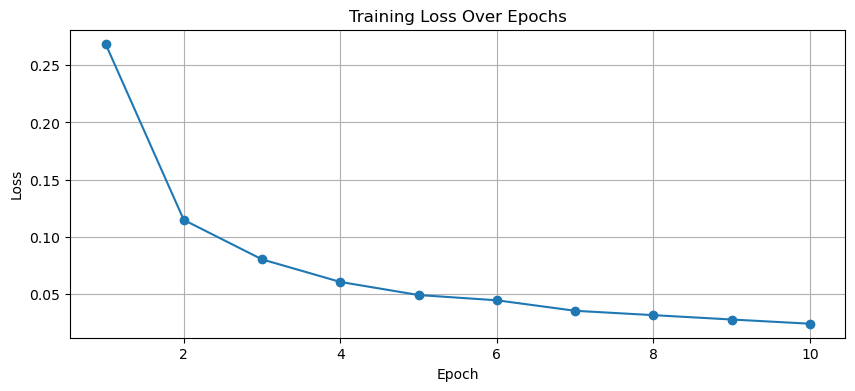

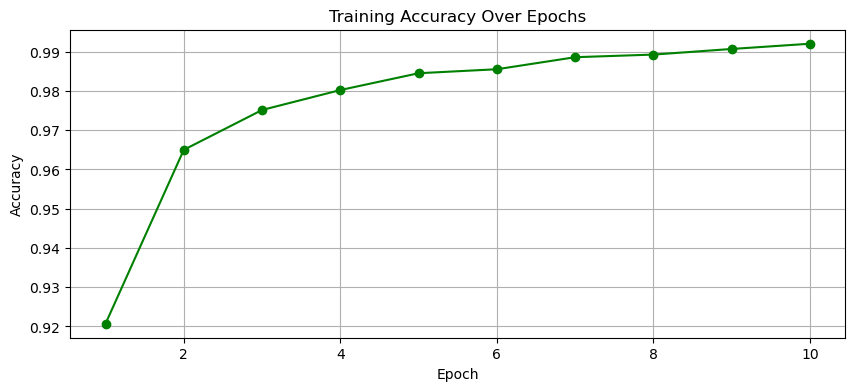

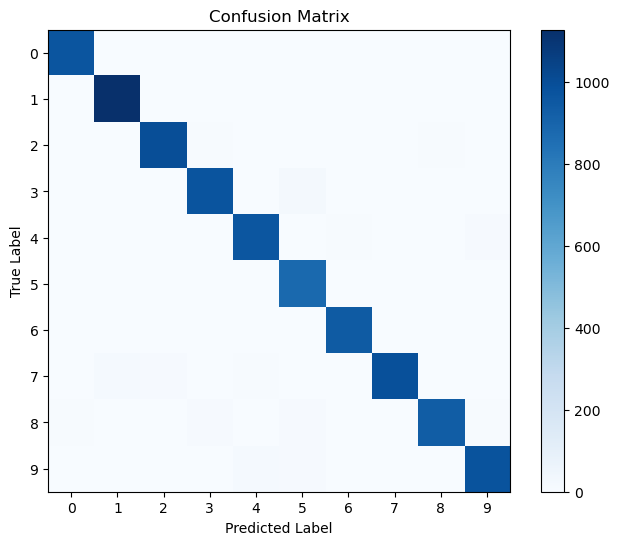

In [74]:
plt.figure(figsize=(10, 4))
plt.plot(range(1, num_epochs+1), train_losses, marker='o')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(range(1, num_epochs+1), train_accuracies, marker='o', color='green')
plt.title("Training Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

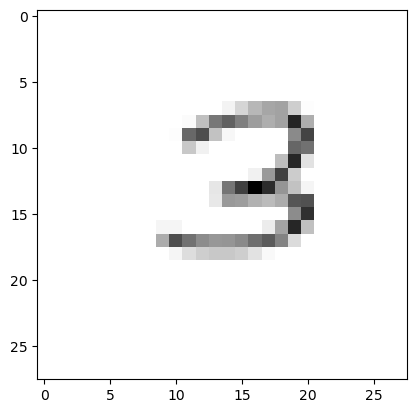

Predicted Digit for 'your_handwritten_digit.png': 3


In [75]:
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms

def predict_external_image_enhanced(image_path, invert_image=False, apply_threshold=True, threshold_value=128):
    image = Image.open(image_path).convert('L')
    if invert_image:
        image = ImageOps.invert(image)
    if apply_threshold:
        img_arr = np.array(image)
        img_arr = (img_arr > threshold_value) * 255
        image = Image.fromarray(img_arr.astype('uint8'), mode='L')
    transform_external = transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    img_tensor = transform_external(image)
    plt.imshow(img_tensor.squeeze(), cmap='gray')
    plt.show()
    img_tensor = img_tensor.unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        _, predicted = torch.max(output, 1)
    return predicted.item()

image_path = 'your_handwritten_digit.png'
prediction = predict_external_image_enhanced(image_path, invert_image=True, apply_threshold=True, threshold_value=128)
print(f"Predicted Digit for '{image_path}': {prediction}")